In [1]:
%matplotlib inline
from google.colab import files
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split #help with organizing the data for training
from sklearn.metrics import confusion_matrix #helps present results as a confusion matrix 

In [2]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp kaggle.json ~/.kaggle/



In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d gti-upm/leapgestrecog

leapgestrecog.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip leapgestrecog.zip

Archive:  leapgestrecog.zip
replace leapGestRecog/00/01_palm/frame_00_01_0001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
imagepaths=[]
for root, dirs, files in os.walk(".",topdown=False):
  for name in files:
    path=os.path.join(root,name)
    if path.endswith("png"):
      imagepaths.append(path)
print(len(imagepaths))       

40000


In [9]:
def plot_image(path):
  img=cv2.imread(path)
  img_cvt=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  print(img_cvt.shape)
  plt.grid(False)
  plt.imshow(img_cvt)
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image"+path)

(240, 640)


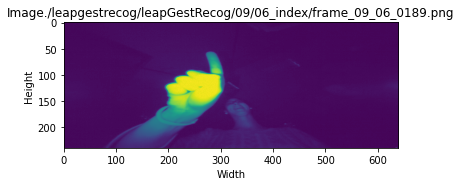

In [10]:
plot_image(imagepaths[0])

In [11]:
X = [] 
y = [] 


for path in imagepaths:
  img = cv2.imread(path) 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (320, 120))
  X.append(img)
  
  
  category = path.split("/")[3]
  label = int(category.split("_")[0][1]) 
  y.append(label)


X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 120, 320, 1) 
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  40000
Labels loaded:  40000
9 ./leapgestrecog/leapGestRecog/09/06_index/frame_09_06_0189.png


In [12]:
ts = 0.2 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

In [13]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

In [14]:
# Construction of model
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']) 

In [ ]:
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))

Epoch 1/5


In [ ]:
model.save('handrecognition_model.h5')

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

In [ ]:
predictions = model.predict(X_test)

In [ ]:
np.argmax(predictions[0]), y_test[0] 

In [ ]:
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
  plt.figure(figsize=(15,5))
  
  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    
    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

In [ ]:
validate_9_images(predictions, y_test, X_test)

In [ ]:
y_pred = np.argmax(predictions, axis=1)

In [ ]:
pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])
